# BOMR 2021

### Dependency installation

In [1]:
!pip install --quiet opencv-python tqdm matplotlib numpy ipywidgets imutils
!jupyter nbextension enable --py widgetsnbextension
!pip install --quiet --upgrade tdmclient

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Imports


In [1]:
import sys as _sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from time import sleep, time
import ipywidgets as widgets
_sys.path.append("./src")

from global_navigation import Path_planner
from vision import Vision
from IPython.display import clear_output
from visualizer import *
from movement import move
from Kalman_filter import Kalman_filter
import tdmclient.notebook
from local_navigation import *
from time import sleep

%matplotlib inline


In [2]:
vision = Vision()
path_planner = Path_planner()


In [3]:
def pltshow(img):
    clear_output(wait = True)
    plt.imshow(img)
    plt.show()
#     plt.imshow(np.zeros((400,600)))
#     plt.show()

#     clear_output(wait = True)

In [2]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

## Connect to camera and calibrate exposure

In [5]:
vision.connect_camera(0)

## Calibration



In [6]:
for i in range(10):
    sleep(0.1)
    vision.update_frame()

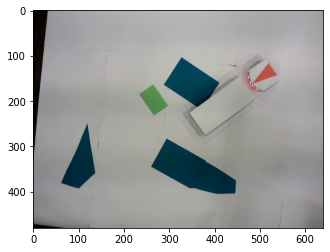

In [7]:
vision.vc.set(15,-7) #exposure
vision.vc.set(11,100) #contrast

vision.update_frame()
im = plt.imshow(vision.actual_frame)

#### set colors of elements

In [8]:
robot_color = np.array([182, 81, 67])
goal_color = np.array([104, 149, 100])
obstacles_color = np.array([6, 63, 84])

vision.set_colors(obstacles_color, robot_color, goal_color)

In [14]:
goalthresh = 20
robotthresh = 40
obstaclesthresh = 40
vision.set_tresh(goalthresh, robotthresh, obstaclesthresh)

### Test vision

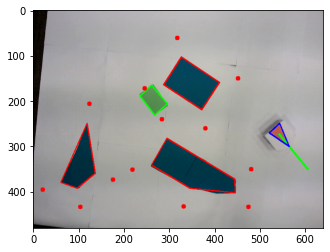

In [15]:
vision.update()
pltshow(vision.create_full_mask())

## set mm to px

In [16]:
vision.set_mm2px()

mm/px ratio :  0.4796028602830496



### Plan path

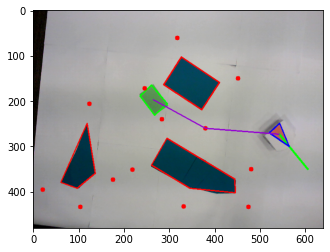

In [17]:
path_planner.make_path(vision)
pltshow(get_visualization(vision, path_planner))

## Run

set_speed(0,0, node)
## lessgo

In [ ]:
set_speed(0,0, node)


In [3]:
await obstacle_avoidance(node, client)


[0, 2352, 3192, 2585, 0]
[5, 7, 6, 0, 0]
[5, 50]
side not set
side not set


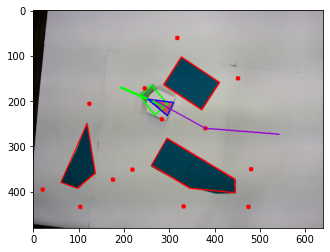

[286.0, 210.0, -2.7403638545849445] [265 197]
24.698178070456937 8.770763282732155 148.24051991518724
arrived at destination


NameError: name 'thymio' is not defined

In [19]:
from IPython.display import clear_output
vision.update_frame()
vision.update_robot()
kalman = Kalman_filter(vision)
plt.figure()
vision.update_robot()
pltshow(get_visualization(vision, path_planner))
next_point_id = 1
next_point = path_planner.path[next_point_id]
# send next_point
# init kalmann
min_dist = 30
t0 = time()

while 1:
    vision.update_frame()
    vision.update_robot()
    robot_speed = get_speed(node)
    # kalman.update_kalman(vision, robot_speed, time() - t0)
    t0 = time()
    pltshow(get_visualization(vision, path_planner))

    if vision.robot_detected():
        pos = [vision.robot.center[0,0], vision.robot.center[0,1], vision.robot.orientation]
        speed_robot,dpos = move(vision, pos, next_point, 0.3, 300,250, 120)
        set_speed(speed_robot[0], speed_robot[1], node)
#         set_speed(0,0)
#         print(speed_robot, dpos, next_point_id)
        # CHECKPOINT 
        
        
        if np.linalg.norm(vision.robot.center - next_point) < min_dist:
            if next_point_id == len(path_planner.path) - 1:
                print("arrived at destination")
                thymio.set_speed(0,0)
                break
            else:
                print("arrived at checkpoint")
                next_point_id += 1
                next_point = path_planner.path[next_point_id]
                

In [50]:
 vision.disconnect_camera()

In [51]:
import tdmclient.notebook
await tdmclient.notebook.start()

Exception: Node lock error

In [ ]:
motor_left_target = kalaman_speed_left
motor_right_target = kalman_speed_right

%%run_python

local_avoid_tresh = 4000

@onevent
def prox():
    global global_mode
    
    x = [0,0,0,0,0] #we only look a the front sensors
    
    for i in range(len(x)):
    # Get and scale inputs
        x[i] = prox_horizontal[i]
        if x[i] >= local_avoid_tresh:
            global_mode = LOCAL_AVOIDANCE


In [ ]:
## local navigation

In [ ]:
%%run_python #%%transpile_to_aseba # Change to show the code generated in Aseba

#IMPORTANT:
#this programm needs to be launched only when the obsatcle is already detected
#i.e. the sensors already saw something
#otherwise it fucks everything up

# The center button restarts and stops the robot

#sates:
#0 the robot stops 
#1 the robot arrives at the obstacle 
#  and choses which side to go around goes forward until the sensor chose (1 left or 5 right) doesnt see anythin
#2 the robot goes forward approx 1 thymio length
#3 the robot rotates until its sensor (1 or 5) sees the obstacle
#4 the robot follows the obstaclke on its length until its sees nothin
#5 the robot goes forward to completely avoid the obstacle 

adjust2 = 2000
close_thresh = 1
time = 0
state = 1
y = [0,0] 
timer_period[0] = 10
time_one_thym_dist = 150
NONE = 0
side = NONE 
constant_scale = 20
adjust = 5    

@onevent
def timer0():
    global prox_horizontal, motor_left_target, motor_right_target, button_center, state, y, NONE, side, time, global_mode
    #side constants
    LEFT = 1
    RIGHT = 2
    
    #asymetric w_l[1] != w_r[1] so the robot choses one side if it arrives straight on the obstacle
    w_l = [10, -15, -10, 6, 0]
    w_r = [-10, -10, 10, 0, 6]

    # Scale factors for sensors and constant factor
    sensor_scale = 400
    
    x = [0,0,0,0,0]
    
    left_prox = prox_horizontal[0]// sensor_scale
    right_prox = prox_horizontal[4]// sensor_scale
    
### STATE 0 the robot stops###    
    if state == 0:
        time = 0
        y = [0,0]
        
### STATE 1  the robot arrives at the obstacle and choses which side to go around###         
    if state == 1:
        # Memory
        x[3] = y[0]//10
        x[4] = y[1]//10        
        
        for i in range(1,4): #we only take the 3 sensors of the middle
            # Get and scale inputs
            x[i-1] = prox_horizontal[i] // sensor_scale
            
        y = [60,60] 
        tot = x[0]+x[1]+x[2]
        
        for i in range(len(x)):    
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + x[i] * w_l[i]
            y[1] = y[1] + x[i] * w_r[i]
        
        if tot < close_thresh :#the three middle sensors see nothing
            if left_prox > close_thresh:
                side = LEFT
            if right_prox > close_thresh:
                side = RIGHT
            if left_prox < close_thresh and right_prox < close_thresh: #the thymio turned and stops only if it sees nothin anymore
                state = 2
    
### STATE 2 and 5 : the robot goes forward approx 1 thymio length ###                   
    if state == 2 or state == 5:
        time += 1         
        if time <= time_one_thym_dist:
            y = [160,160]
        elif time > time_one_thym_dist:
            y = [0,0]
            if state == 2:
                time = 0
                state = 3
            if state == 5:
                time = 0
                state = 0
                global_state = GLOBAL_NAVIG
            
### STATE 3 the robot rotates until its sensor (1 or 5) sees the obstacle###   
    if state == 3: 
        if side == RIGHT:
            if right_prox <= close_thresh + adjust:
                y = [160,0]
            if right_prox > close_thresh + adjust:
                state = 4
        if side == LEFT:
            if left_prox <= close_thresh + adjust:
                y = [0,160]
            if left_prox > close_thresh + adjust:
                state = 4
                
### STATE 4 the robot follows the obstacle on its length until its sees nothing###             
    if state == 4:
        left_prox_adjust = left_prox -adjust2//sensor_scale
        right_prox_adjust = right_prox -adjust2//sensor_scale
        if side == RIGHT:
            y = [80,80+right_prox_adjust*constant_scale]
        if side == LEFT:
            y = [80+left_prox_adjust*constant_scale,80]
        if left_prox < close_thresh and right_prox < close_thresh:
            state = 5
        
    # Set motor powers
    motor_left_target = y[0]
    motor_right_target = y[1]           